In [4]:
import os
from typing import List

import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import tv_tensors
from torchvision.transforms import v2
from tqdm import tqdm

# from .transforms import rt_detr_train_transform


class YoloVideoDataset(Dataset):
    def __init__(
        self,
        root_dir,
        split: str = "train",
        transform: v2.Compose = None,
        num_samples: int = None,
        number_frames: int = 5,
    ):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.number_frames = number_frames

        self.images_paths = os.listdir(os.path.join(self.root_dir, "images"))
        self.labels_paths = os.listdir(os.path.join(self.root_dir, "labels"))

        # create the image path to label path dict
        self.image_to_label = {}
        missing_labels = []
        for img in tqdm(self.images_paths):
            file_ext = os.path.splitext(img)[1]
            img_base = os.path.basename(img)[: -len(file_ext)]
            if img_base in self.image_to_label:
                raise ValueError(f"Duplicate image {img_base} found")
            if f"{img_base}.txt" not in self.labels_paths:
                print(f"Label for image {img_base} not found")
                missing_labels.append(img)
                continue
            self.image_to_label[img] = f"{img_base}.txt"

        # Remove images without labels from self.images_paths
        for img in missing_labels:
            self.images_paths.remove(img)

        print(f"Total images after initial filtering: {len(self.images_paths)}")
        print(f"Total labels: {len(self.labels_paths)}")

        self.remove_images()
        self.images_paths = self.images_paths[:num_samples]
        
    def remove_images(self):
        """Function to remove images without labels or without labels within -5 of the image index"""
        imgs_to_remove = set()
        print(f"Total images: {len(self.images_paths)}")
        for image in tqdm(self.images_paths):
            label_path = os.path.join(
                self.root_dir, "labels", self.image_to_label[image]
            )
            if not os.path.exists(label_path):
                imgs_to_remove.add(image)
            else:
                with open(label_path, "r") as f:
                    labels = f.readlines()
                    if len(labels) == 0:
                        imgs_to_remove.add(image)
            # now we check that the image -1, -2, -3, -4, -5 exists
            im_num = int(image.split("_")[-1].split(".")[0])
            dataset_cam_name = image.split("/")[-1].split("___")[0]
            for i in range(1, 6):
                check_im_num = im_num - i
                check_im_path = os.path.join(self.root_dir, "images", f"{dataset_cam_name}___frame_{check_im_num:04d}.jpg")
                if not os.path.exists(check_im_path):
                    imgs_to_remove.add(image)
                    break
        for img in imgs_to_remove:
            self.images_paths.remove(img)
            self.labels_paths.remove(self.image_to_label[img])
        print(f"Removed {len(imgs_to_remove)} images without labels or without labels within -5 of the image index")
        print(f"Total images: {len(self.images_paths)}")

    def __len__(self):
        return len(self.images_paths)

    
    def __getitem__(self, idx):
        """This will get the frame and the previous 5 frames - stacking them"""
        imgs = []
        labels = []
        im_num = int(self.images_paths[idx].split("_")[-1].split(".")[0])
        dataset_cam_name = self.images_paths[idx].split("/")[-1].split("___")[0]
        for i in range(0, self.number_frames):
            new_im_num = im_num - i
            if new_im_num < 0:
                break
            im_path = os.path.join(self.root_dir, "images", f"{dataset_cam_name}___frame_{new_im_num:04d}.jpg")
            if not os.path.exists(im_path):
                print(f"Image {im_path} not found")
                break
            imgs.append(Image.open(im_path).convert("RGB"))
        
        height = imgs[0].height
        width = imgs[0].width
        
        if len(imgs) < self.number_frames:
            return
        
        label_path = os.path.join(
            self.root_dir, "labels", self.image_to_label[self.images_paths[idx]]
        )
        with open(label_path, "r") as f:
            labels = f.readlines()
        labels = [label.strip().split() for label in labels]
        labels = [
            [
                int(label[0]),
                float(label[1]) * width,
                float(label[2]) * height,
                float(label[3]) * width,
                float(label[4]) * height,
            ]
            for label in labels
        ]
        bboxes = tv_tensors.BoundingBoxes(
            torch.Tensor(
                [[label[1], label[2], label[3], label[4]] for label in labels]
            ),
            format=tv_tensors.BoundingBoxFormat.CXCYWH,
            canvas_size=(height, width),
        )
        final_annotation = {
            "boxes": bboxes,
            "labels": torch.Tensor([label[0] for label in labels]).long(),
        }
        
        imgs, labels = self.transform((imgs, final_annotation))

        height = imgs[0].shape[-2]
        width = imgs[0].shape[-1]
        labels["boxes"][:, [0, 2]] /= width
        labels["boxes"][:, [1, 3]] /= height
        labels["img_name"] = self.images_paths[idx]
        sample = {
            "image": torch.stack(imgs).contiguous(),
            "annotations": labels,
        }
        return sample


    def collate_fn(batch: List[dict]):
        images = [item["image"] for item in batch]
        annotations = [item["annotations"] for item in batch]
        return torch.stack(images), annotations

img_size = 256
transform = v2.Compose(
        [
            v2.Resize((img_size, img_size)),
            v2.RandomZoomOut(side_range=(1, 2)),
            v2.RandomPhotometricDistort(
                brightness=(0.875, 1.125),
                contrast=(0.5, 1.5),
                saturation=(0.5, 1.5),
                hue=(-0.05, 0.05),
            ),
            v2.RandomIoUCrop(
                min_scale=0.2,
                max_scale=1.0,
                min_aspect_ratio=0.5,
                max_aspect_ratio=2.0,
                sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                trials=40,
            ),
            v2.SanitizeBoundingBoxes(min_size=1),
            v2.Resize((img_size, img_size)),
            v2.RandomHorizontalFlip(),
            v2.ToTensor(),
    ]
)


/Users/derek/Desktop/drone-tracking-datasets/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
dataset = YoloVideoDataset(
    "/Users/derek/Desktop/drone-tracking-datasets/yolo_dataset", 
    "train", 
    transform=transform, 
)


100%|██████████| 2923/2923 [00:00<00:00, 77159.02it/s]


Label for image dataset1_cam0___frame_5338 not found
Label for image dataset1_cam0___frame_5339 not found
Label for image dataset1_cam0___frame_5335 not found
Label for image dataset1_cam0___frame_5337 not found
Label for image dataset1_cam0___frame_5336 not found
Total images after initial filtering: 2918
Total labels: 2918
Total images: 2918


100%|██████████| 2918/2918 [00:00<00:00, 25131.32it/s]

Removed 59 images without labels or without labels within -5 of the image index
Total images: 2859


In [6]:
output = dataset[0]

In [11]:
output['annotations']

{'boxes': BoundingBoxes([[0.2909, 0.1973, 0.0552, 0.0464]], format=BoundingBoxFormat.CXCYWH, canvas_size=(256, 256)),
 'labels': tensor([0]),
 'img_name': 'dataset1_cam0___frame_3616.jpg'}

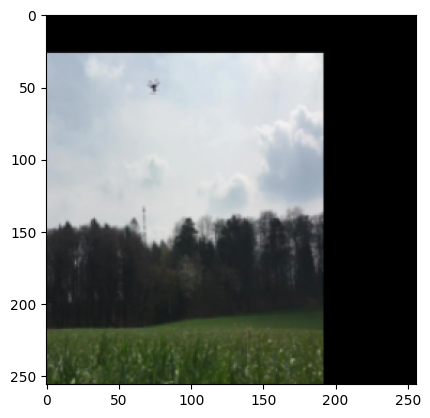

In [8]:
import matplotlib.pyplot as plt
plt.imshow(output["image"][0].permute(1, 2, 0))
plt.show()


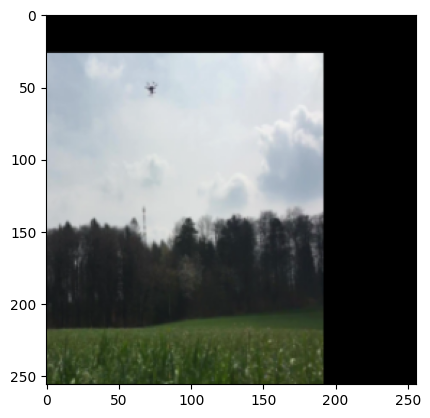

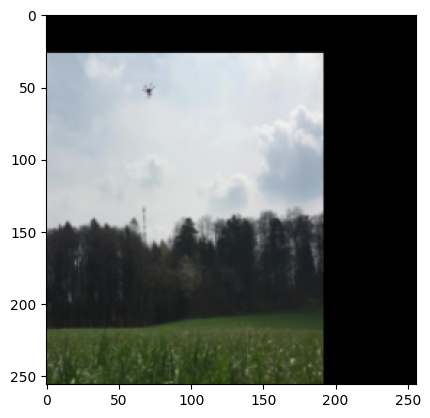

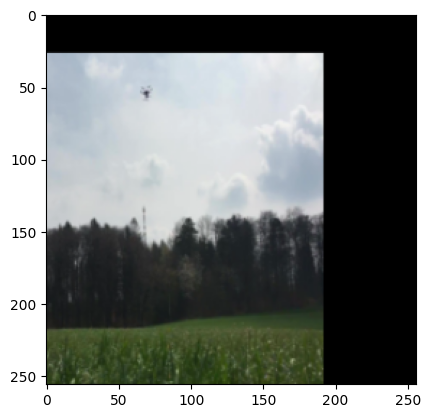

In [9]:
plt.imshow(output["image"][1].permute(1, 2, 0))
plt.show()

plt.imshow(output["image"][2].permute(1, 2, 0))
plt.show()

plt.imshow(output["image"][3].permute(1, 2, 0))
plt.show()



In [30]:
import os

images = os.listdir("/Users/derek/Desktop/drone-tracking-datasets/yolo_dataset/train/images")
"dataset1_cam0_frame_2459.jpg" in images

True